# Lecture 6 - Bayesian Binary Logistic Regression

## Today's Learning Objectives

1. Extend the paradigm of Bayesian regression to Generalized Linear Models (GLMs), specifically Binary Logistic regression.
2. Explore and contrast Bayesian Binary Logistic regression versus its frequentist counterpart.
3. Illustrate the Bayesian modelling setup in Binary Logistic regression.
4. Compare the Bayesian prior and posterior sigmoid curves in simple Binary Logistic regression.
5. Compare the Bayesian prior and posterior predicted probabilities in simple Binary Logistic regression.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 6)
library(bayesrules)
library(tidyverse)
library(broom)
library(rstan)
library(bayesplot)
library(broom.mixed)
library(cowplot)
library(janitor)
library(wesanderson)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: StanHeaders




rstan version 2.32.6 (Stan version 2.32.2)




For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)





Attaching package: ‘rstan’




The following object is masked from ‘package:tidyr’:

    extract




This is bayesplot version 1.11.1



- Online documentation and vignettes at mc-stan.org/bayesplot



- bayesplot theme set to bayesplot::theme_default()



   * Does _not_ affect other ggplot2 plots



   * See ?bayesplot_theme_set for details on theme setting




Attaching package: ‘cowplot’




The following object is masked from ‘package:lubridate’:

    stamp





Attaching package: ‘janitor’




The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




## Previously...

We introduced Bayesian Normal regression, **comparable to Ordinary Least-Squares (OLS)**. Nonetheless, we tweaked the frequentist concepts to a Bayesian framework. For instance, we do not use $p$-values in a Bayesian framework to perform inference. Nevertheless, we can use posterior credible intervals to test whether a given regression coefficient is different from zero (i.e., **whether the credible interval contains zero or not**).

Furthermore, we know there are more regression models besides the classical OLS. As we saw in [**DSCI 562**](https://ubc-mds.github.io/DSCI_562_regr-2/_images/reg-mindmap-7.png), we will encounter different types of responses. Hence, there is always a specific regression model for each possible case. Recall GLMs, such as Binary Logistic regression, are estimated via **maximum likelihood**.

GLMs also have a Bayesian version, and we can obtain an approximate posterior for the regression parameters via Markov Chain Monte Carlo (MCMC)!

## 1. Cards Against Humanity's "Pulse of the Nation" Survey

We will use the dataset `pulse_of_the_nation` found in the package `bayesrules` **to contrast Bayesian Binary Logistic regression versus its frequentist counterpart**.

According to the package's documentation, the description is the following:

> *Cards Against Humanity's "Pulse of the Nation" project (https://thepulseofthenation.com/) conducted monthly polls into people's social and political views, as well as some silly things. This data includes responses to a subset of questions included in the poll conducted in September 2017.*

The dataset contains $n = 1000$ observations (i.e., surveyed subjects) and fifteen variables.

In [2]:
pulse_of_the_nation

income,age,party,trump_approval,education,robots,climate_change,transformers,science_is_honest,vaccines_are_safe,books,ghosts,fed_sci_budget,earth_sun,wise_unwise
<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<lgl>,<fct>
8,64,Democrat,Strongly disapprove,College degree,Unlikely,Real and Caused by People,1,Strongly Agree,Somewhat Disagree,20,Yes,Too Low,FALSE,Wise but Unhappy
68,56,Democrat,Strongly disapprove,High school,Unlikely,Real and Caused by People,0,Somewhat Agree,Somewhat Disagree,6,No,Too High,FALSE,Wise but Unhappy
46,63,Independent,Somewhat Approve,Some college,Unlikely,Real but not Caused by People,0,Somewhat Agree,Strongly Agree,0,No,About Right,TRUE,Happy but Unwise
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
70,74,Republican,Strongly Approve,Some college,Unlikely,Real and Caused by People,0,Somewhat Agree,Neither Agree nor Disagree,3,No,Too High,FALSE,Wise but Unhappy
93,60,Independent,Strongly disapprove,Graduate degree,Unlikely,Real but not Caused by People,0,Somewhat Disagree,Strongly Agree,4,Yes,Too Low,TRUE,Happy but Unwise
35,46,Independent,Strongly Approve,High school,Likely,Not Real At All,3,Strongly Agree,Strongly Agree,0,No,About Right,TRUE,Happy but Unwise


We are interested in the following variables:

- `income`: Subject's annual income in thousand USD. It is a **continuous variable**.
- `climate_change`: Subject's belief in climate change. It is a **categorical variable** with three levels (`Not Real At All`, `Real and Caused by People`, `Real but not Caused by People`,).

In [3]:
pulse_training <- pulse_of_the_nation |>
  select(income, climate_change)
pulse_training
levels(pulse_training$climate_change)

income,climate_change
<dbl>,<fct>
8,Real and Caused by People
68,Real and Caused by People
46,Real but not Caused by People
⋮,⋮
70,Real and Caused by People
93,Real but not Caused by People
35,Not Real At All


[1] "Not Real At All"               "Real and Caused by People"    
[3] "Real but not Caused by People"

```{admonition} Main statistical inquiries
Suppose we are interested in the following statistical inquiries:

1. How is continuous `income` associated with `climate_change`?
2. Is there a numerical result that can quantify this association?
```

```{exercise}
:label: lecture6-q1

We will view `climate_change` as our response of interest and `income` as our feature. Thus, regression analysis will help you address these inquiries. Now, the question is: **what regression model should we use via a frequentist approach??**

**A.** A generalized linear model (GLM) such as Multinomial regression.

**B.** A GLM such as Ordinal Logistic regression.

**C.** A GLM such as Poisson regression.

**D.** Ordinary Least-squares (OLS).
```

**We need to start with a simple approach as a Bayesian GLM.** Therefore, let us convert `climate_change` to a binary response: `1` for `Real and Caused by People` and `Real but not Caused by People`, along with `0` for `Not Real At All`.

In [4]:
levels(pulse_training$climate_change)

[1] "Not Real At All"               "Real and Caused by People"    
[3] "Real but not Caused by People"

In [5]:
pulse_training <- pulse_training |>
  mutate(climate_change = case_when(
    climate_change == "Real and Caused by People" ~ 1,
    climate_change == "Real but not Caused by People" ~ 1,
    climate_change == "Not Real At All" ~ 0
  ))
pulse_training

income,climate_change
<dbl>,<dbl>
8,1
68,1
46,1
⋮,⋮
70,1
93,1
35,0


## 2. Exploratory Data Analysis

Let us make a quick exploratory data analysis on `pulse_training` for `climate_change` versus `income` via side-by-side boxplots. Moreover, **note 15% of the respondents believe climate change is not real!**

In [6]:
pulse_training |> 
  tabyl(climate_change) |>
  adorn_pct_formatting()

climate_change,n,percent
<dbl>,<dbl>,<chr>
0,150,15.0%
1,850,85.0%


The below side-by-side boxplots show **graphical** evidence for lower incomes leaning more to the category **Not Real** in `climate_change`.

In [7]:
options(repr.plot.height = 8, repr.plot.width = 12)

climate_change_boxplots <- pulse_training |>
  ggplot(aes(as.factor(climate_change), income)) +
  geom_boxplot(aes(fill = as.factor(climate_change))) +
  labs(y = "Income (Thousand USD)", x = "Climate Change Belief") +
  ggtitle("Side-by-Side Boxplots") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) + 
  scale_x_discrete(labels=c("0" = "Not Real", "1" = "Real")) + 
  scale_fill_manual(values = wes_palette(n = 3, name = "GrandBudapest1"))

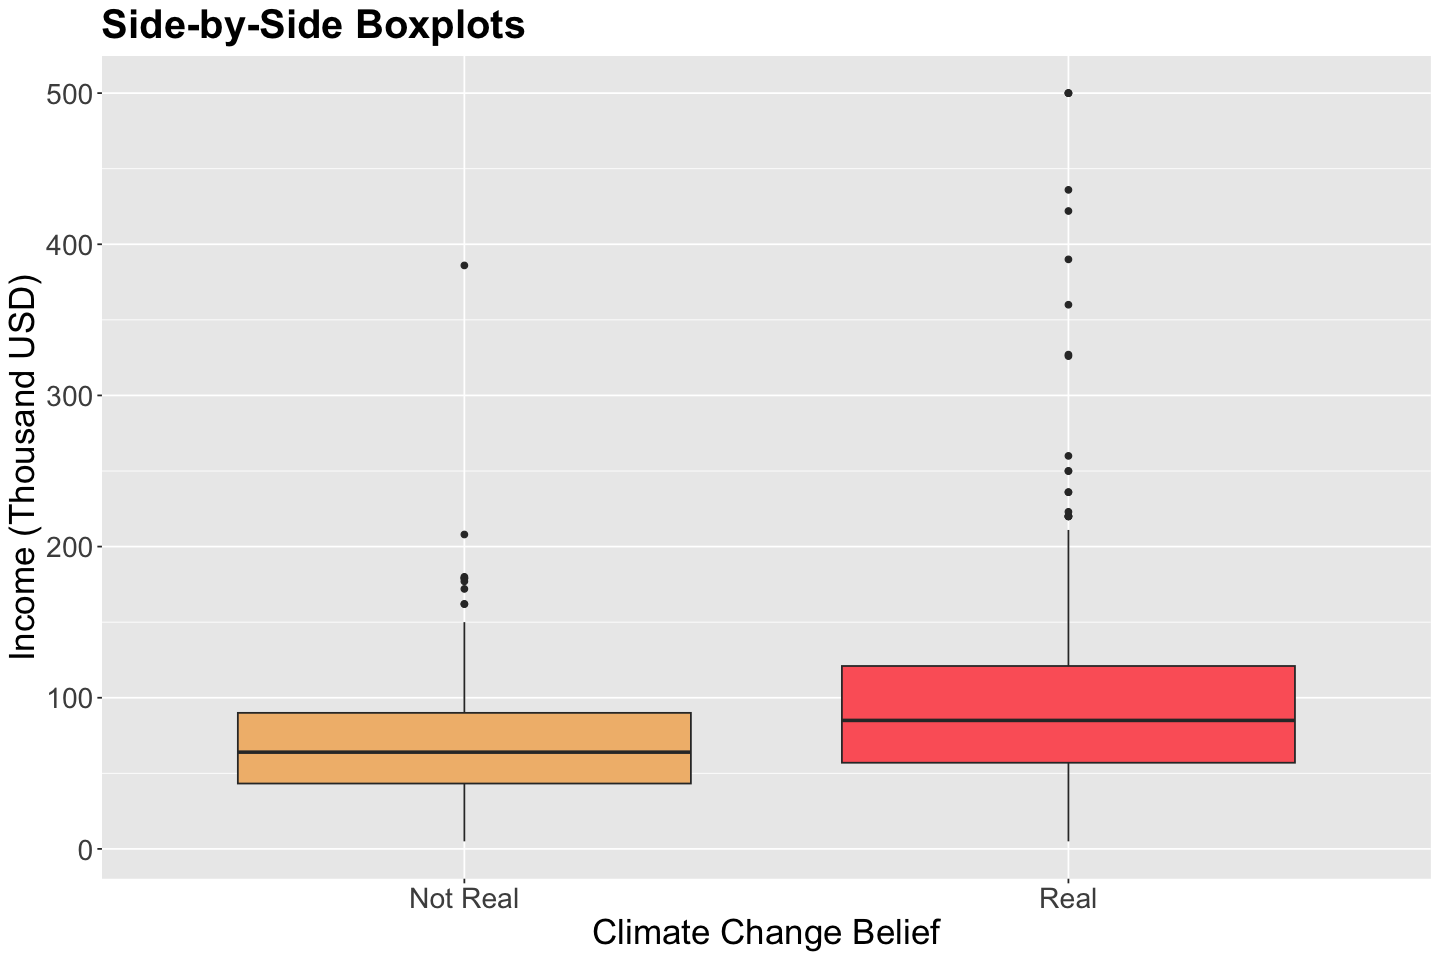

In [8]:
climate_change_boxplots

## 3. Frequentist Logistic Regression

Let us review the frequentist Binary Logistic regression. For $i = 1, \dots, n$ (where $n$ is the training size) its response variable has the form:

```{math}
\begin{equation*}
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th observation is a success},\\
0 \; \; \; \; \mbox{otherwise.}
\end{cases}
\end{equation*}
```

As the response variable can only take the values $0$ or $1$, the key modelling term becomes the probability that $Y_i$ takes on the value of $1$, i.e. the probability of success, denoted as $\pi_i$. Hence:

```{math}
\begin{equation*}
Y_i \sim \text{Bernoulli}(\pi_i).
\end{equation*}
```

Specifically, $\pi_i$ ($i = 1, 2, \dots, n$) will depend on the values of the $k$ regressors $X_{i, 1}, X_{i, 2}, \dots, X_{i, k}$ in the form:

```{math}
\begin{equation*}
\log \bigg( \frac{\pi_i}{1 - \pi_i}\bigg) = \beta_0 + \beta_1 X_{i, 1} + \beta_1 X_{i, 2} + \ldots + \beta_k X_{i, k},
\end{equation*}
```

or equivalently

```{math}
\begin{equation*}
\pi_i = \frac{\exp\big[\beta_0 + \beta_1 X_{i, 1} + \beta_2 X_{i, 2} + \ldots + \beta_k X_{i, k}\big]}{1 + \exp\big[\beta_0 + \beta_1 X_{i, 1} + \beta_2 X_{i, 2} + \ldots + \beta_k X_{i, k}\big]} \in [0,1].
\end{equation*}
```

The log of the odds $\log \bigg( \frac{\pi_i}{1 - \pi_i}\bigg) $ is the link function in this GLM, i.e., **the logarithm of the ratio of the probability of the event to the probability of the non-event**. 

In this example, let: 

```{math}
\begin{equation*}
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th subject thinks climate change is real},\\
0 \; \; \; \; \mbox{otherwise;}
\end{cases}
\end{equation*}
```

and $X_{i,\text{income}}$ our single regressor. 

Hence, the model becomes:

```{math}
\begin{equation*}
\log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{i,\text{income}}.
\end{equation*}
```

Note we have two regression parameters: $\beta_0$ and $\beta_1$. **These parameters will be unrestricted on the real scale.**

Firstly, we run a frequentist Binary Logistic regression via `glm()` (i.e., **using maximum likelihood estimation**). Note the following:

- `income` is statistically significant for the log of the odds.
- The interpretation for $\hat{\beta}_1$ is: "*for each one thousand USD increase in `income`, a subject is 1.009 times more likely to believe in climate change than not to*".

In [9]:
freq_log_reg <- glm(climate_change ~ income, data = pulse_training, family = "binomial")
summary_freq_log_reg <- tidy(freq_log_reg, conf.int = TRUE) |>
  mutate(
    exp.estimate = exp(estimate),
    exp.conf.low = exp(conf.low),
    exp.conf.high = exp(conf.high)
  ) %>%
  mutate_if(is.numeric, round, 3)
summary_freq_log_reg

term,estimate,std.error,statistic,p.value,conf.low,conf.high,exp.estimate,exp.conf.low,exp.conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.965,0.184,5.248,0,0.606,1.327,2.625,1.834,3.771
income,0.009,0.002,4.376,0,0.005,0.014,1.009,1.005,1.014


The log of the odds can be put on the probability scale as follows:

```{math}
\begin{equation*}
\pi_i = \frac{\exp\big[\beta_0 + \beta_1 X_{i,\text{income}}\big]}{1 + \exp\big[\beta_0 + \beta_1 X_{i,\text{income}}\big]} \in [0 ,1].
\end{equation*}
```

This is the **sigmoid function**. The in-sample $\hat{\pi}_i$ values are shown below. There is no $S$-shaped in this case given the values for $\hat{\beta}_0$ and $\hat{\beta}_1$

In [10]:
plot_freq_log_reg <- pulse_training |>
  ggplot() +
  geom_point(aes(income, climate_change)) +
  geom_smooth(aes(income, climate_change), 
    method = "glm", method.args = c(family = binomial), formula = "y ~ x", se = FALSE, color = "red") +
  labs(y = "Probability of Believing Climate Change is Real", x = "Income (Thousand USD)") +
  ggtitle("In-Sample Estimated Sigmoid Function in Frequentist Logistic Regression") +
  theme(
    plot.title = element_text(size = 22, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  )

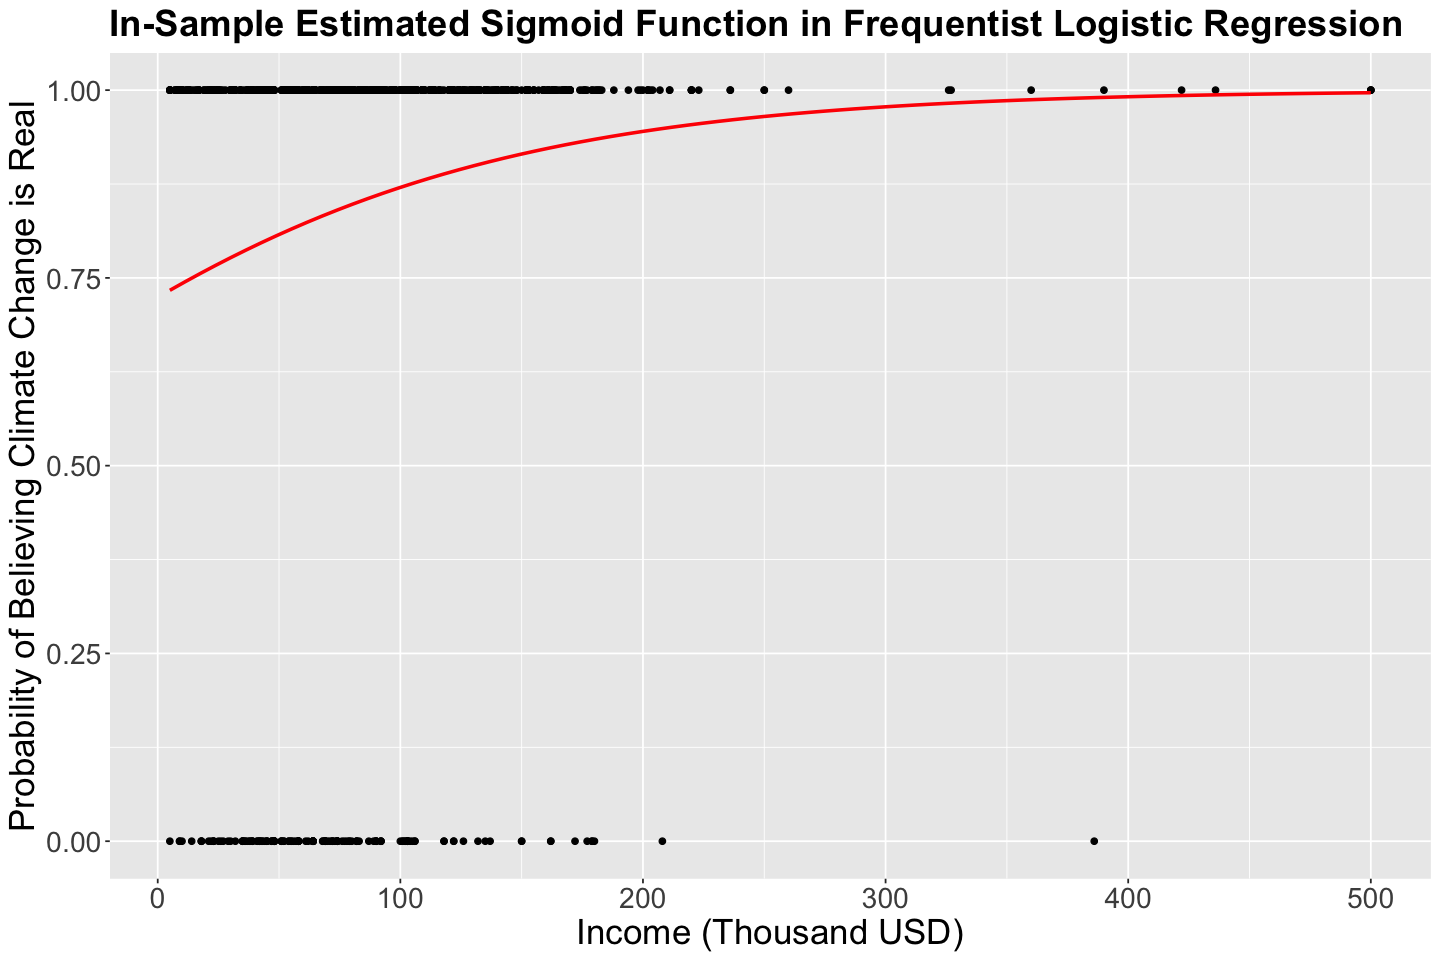

In [11]:
plot_freq_log_reg

## 4. Bayesian Logistic Regression

### 4.1.  The Likelihood

Let us start our Bayesian model. First off, our respose will be assumed as:

$$Y_i \mid \beta_0, \beta_1 \mathop\sim^\text{ind} \text{Bernoulli}(\pi_i).$$

We need to set up the **systematic component** of the model. Thus, we will use the link function:

```{math}
\begin{equation*}
\log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{i,\text{income}}.
\end{equation*}
```

This will be our likelihood:

$$Y_i \mid \beta_0, \beta_1 \mathop\sim^\text{ind} \text{Bernoulli}(\pi_i) \quad \text{where} \quad \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{i,\text{income}}.$$

### 4.2.  The Priors

**Unlike OLS, we do not have $\sigma^2$.** Therefore, our parameters of interest are $\beta_0$ and $\beta_1$. For the prior specification, we will proceed as follows:

- $\beta_0 \sim \mathcal{N}(\mu_{\beta_0} = 0, \sigma_{\beta_0}^2 = 100^2)$.
- $\beta_1 \sim \mathcal{N}(\mu_{\beta_1} = 0, \sigma_{\beta_1}^2 = 100^2)$.

We have to stress that for these prior specifications, **we assume the prior mean of $\beta_1$ as $0$, since we do not know if the variable $X_{i,\text{income}}$ has any association with $Y_i$**. On the other hand, **the intercept $\beta_0$ will be assumed as zero in our prior knowledge**. We will use a large variances (i.e, $\sigma_{\beta_j}^2 = 100^2$ for $j = 0, 1$) **to reflect uncertainty**.

The density plot for these priors is shown below with the corresponding hyperparameter mean (equal to zero) indicated as red vertical dashed line.

In [12]:
# Plotting Normal prior for regression parameters
prior_gamma_beta_j <- ggplot() +
  xlim(-500, 500) +
  ylim(0, 0.005) +
  geom_function(fun = dnorm, args = list(mean = 0, sd = 100), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(beta["j"])) +
  ggtitle("Prior Distribution for Regression Parameters") +
  geom_vline(xintercept = 0, colour = "darkred", linetype = "dashed", linewidth = 1)

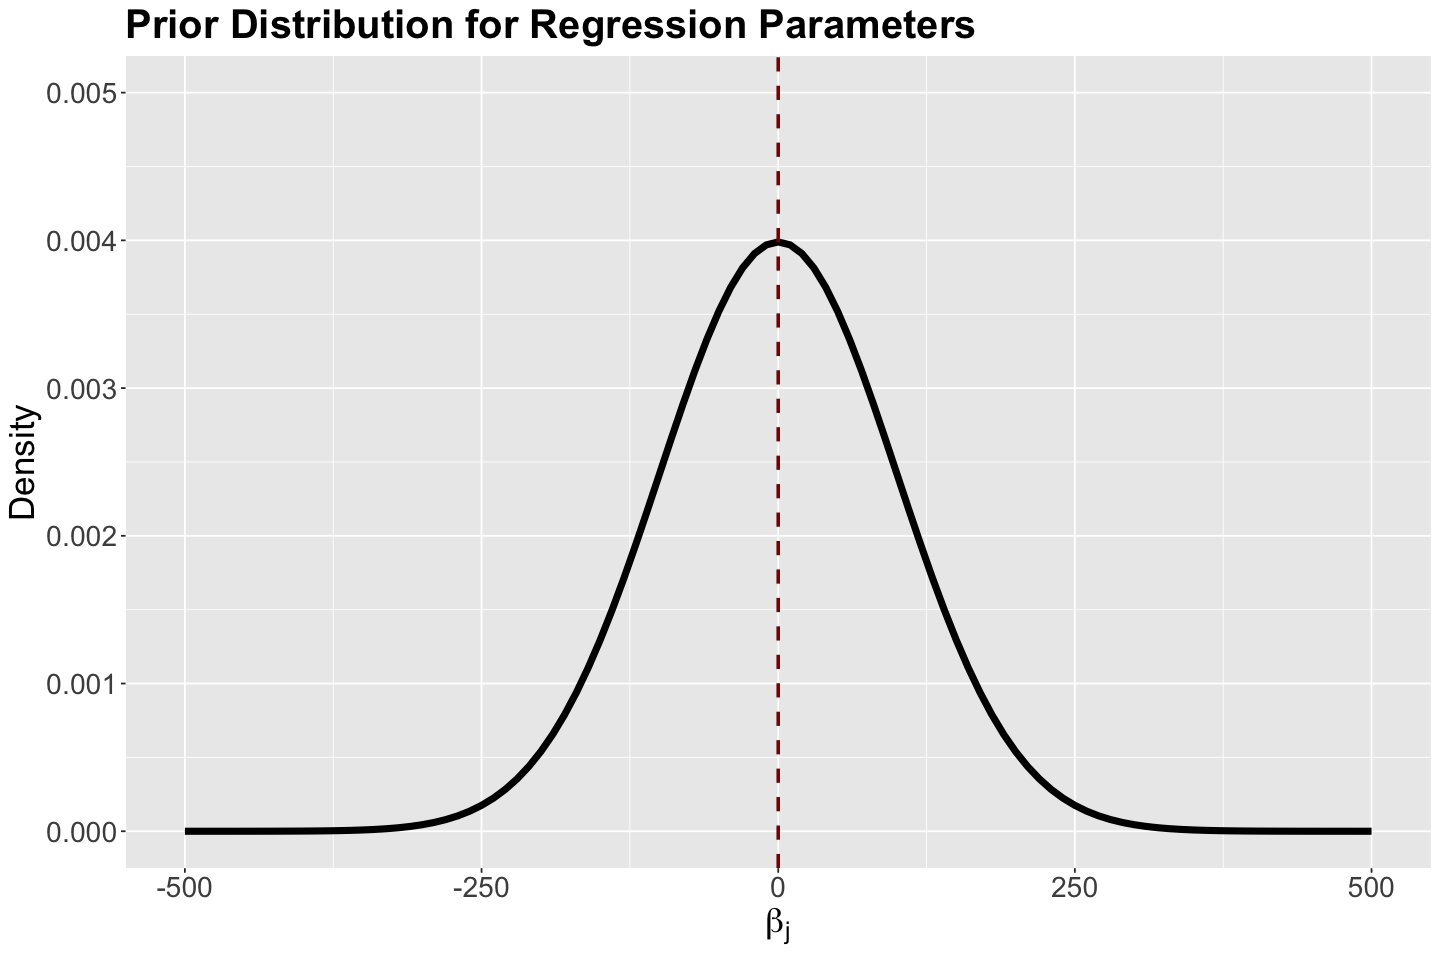

In [13]:
prior_gamma_beta_j

### 4.3.  Coding a Prior Bayesian Model on `Stan`

**Before setting up our full Bayesian model, we will check why our likelihood (i.e., collected data) is essential.** Suppose you set up a prior Bayesian model, i.e., you only code the prior distributions for $\beta_0$ and $\beta_1$ in `Stan`. 

**What does this mean?** It means that we build a `Stan` code with the prior distribution of the `parameters` without specifying the likelihood and `data` block. Hence, the process becomes a Monte Carlo simulation in which we draw random values from the two prior normal distributions. 

```{caution}
This is not MCMC since we are not applying the Bayes' rule.
```

In [14]:
prior_stan_climate_change <- "parameters {
real beta_0;
real beta_1;
}
model {
beta_0 ~ normal(0, 100);        
beta_1 ~ normal(0, 100);
}"

Therefore, when using the function `stan()` (or `sampling()` if we are using the `R` markdown), using `thin` and `warmup` might not be necessary. Furthermore, you do not need a `data` dictionary in this prior model.

In [15]:
prior_climate <- stan(
  model_code = prior_stan_climate_change,
  chains = 1,
  iter = 1000,
  warmup = 0,
  thin = 1,
  seed = 553
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: WARNING: No variance estimation is
Chain 1:          performed for num_warmup < 20
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Sampling)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Sampling)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Sampling)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Sampling)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Sampling)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.13 s

The output `prior_climate` will contain **the prior samples for $\beta_0$ and $\beta_1$**. Note the summary statistics are close to the hyperparameters we set up in `prior_stan_climate_change`.

In [16]:
prior_climate_samples <- as.data.frame(round(summary(prior_climate)$summary, 3))
prior_climate_samples <- prior_climate_samples[, c("mean", "sd")]
prior_climate_samples[1:2,]

,mean,sd
,<dbl>,<dbl>
beta_0,0.732,108.576
beta_1,-0.062,99.967


We plot the prior histograms for these samples via `mcmc_hist()` from `bayesplot`. The distributions are symmetric and centred around zero.

In [17]:
prior_plots_betas <- mcmc_hist(prior_climate, pars = c("beta_0", "beta_1")) +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text.x = element_text(size = 17, family = "sans"),
    axis.text.y = element_text(size = 17, family = "sans"),
    strip.text.x = element_text(size = 21, family = "sans")
  ) +
  ggtitle("Prior Histograms by Parameter of Interest")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


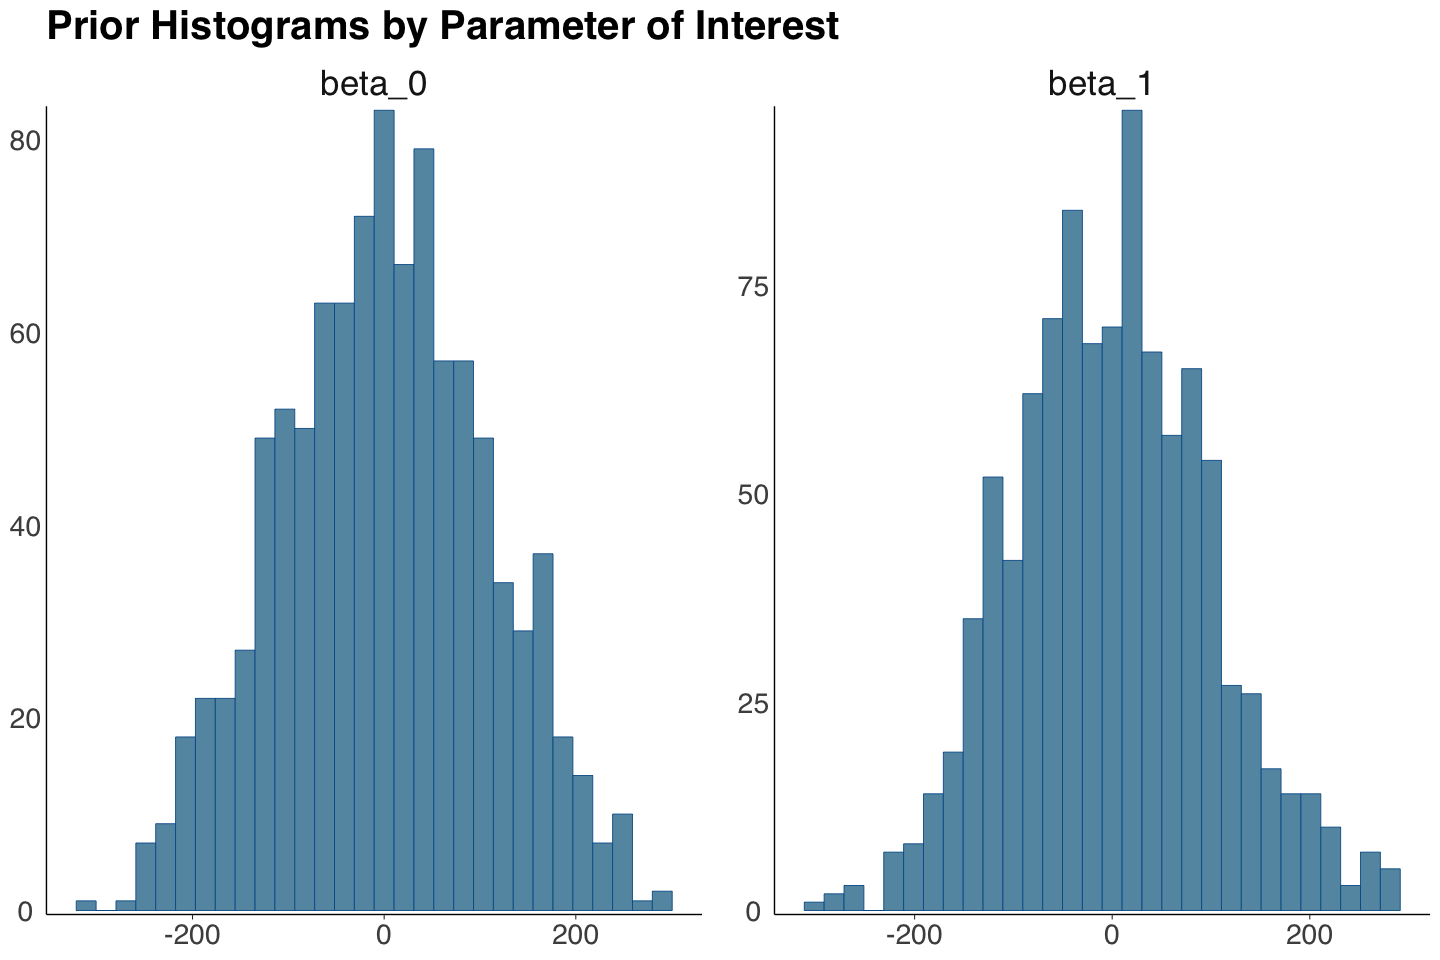

In [18]:
prior_plots_betas

**What is the purpose of getting these prior samples?** These 1000 samples (pairs containing $\beta_0$ and $\beta_1$) will be use to plot 1000 different sigmoid functions:

```{math}
\begin{equation*}
\pi_i = \frac{\exp\big[\beta_0 + \beta_1 X_{i,\text{income}}\big]}{1 + \exp\big[\beta_0 + \beta_1 X_{i,\text{income}}\big]} \in [0 ,1]
\end{equation*}
```

The regressor income is set up as a grid from 0 to 500 thousand USD to plot these 1000 sigmoid functions.

In [19]:
prior_climate <- as.data.frame(prior_climate) # prior_climate as data frame

income <- seq(0, 500, length.out = 500) # Setting up grid for income

beta_0 <- as.numeric(prior_climate[1, "beta_0"]) # First sample
beta_1 <- as.numeric(prior_climate[1, "beta_1"]) # First sample

logistic_like <- data.frame(income = income) |> # Computing probabilities with first sample
  mutate(values = exp(beta_0 + beta_1 * income) / (1 + exp(beta_0 + beta_1 * income)))

plot_logistic_like_prior_stanfit <- ggplot(data = logistic_like, na.rm = TRUE) +
  geom_line(aes(x = income, y = values), alpha = 0.1, color = "darkblue", na.rm = TRUE) +
  labs(y = "Probability of Believing Climate is Real", x = "Income (Thousand USD)") +
  ggtitle("Prior Sigmoid Functions") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) # First ggplot layer

for (j in 2:nrow(prior_climate)) # Loop from the second sample to the last sample in prior_climate
{
  beta_0 <- as.numeric(prior_climate[j, "beta_0"])
  beta_1 <- as.numeric(prior_climate[j, "beta_1"])
    
  logistic_like <- data.frame(income = income) |>
    mutate(values = exp(beta_0 + beta_1 * income) / (1 + exp(beta_0 + beta_1 * income)))
    
  plot_logistic_like_prior_stanfit <- plot_logistic_like_prior_stanfit +
    geom_line(data = logistic_like, aes(x = income, y = values), 
              alpha = 0.4, color = "darkblue", na.rm = TRUE) # Next ggplot layer
}

The plot below shows these 1000 sigmoid functions. We can think of this as **a prior distribution over curves** (since a curve is defined by $\beta_0$ and $\beta_1$). Hence, these blue sigmoid curves are samples from this distribution.

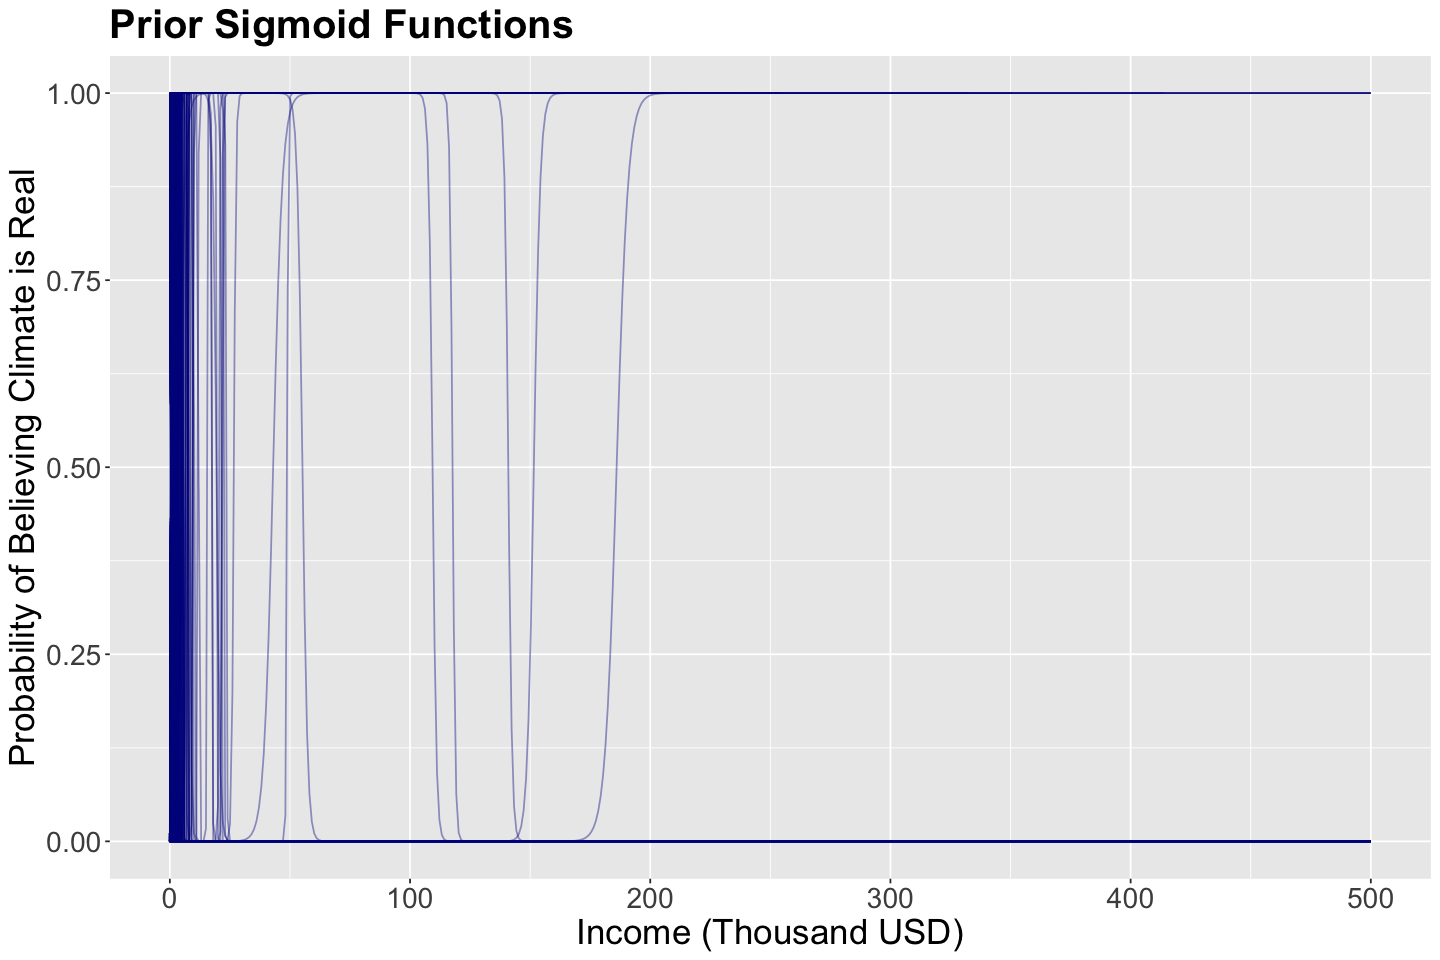

In [20]:
plot_logistic_like_prior_stanfit

```{exercise}
:label: lecture6-q2

Having explained all this prior model, do you see a clear distribution on these fitted curves?

**A.** Yes.

**B.** No.
```

### 4.4. Coding the Posterior Bayesian Model on `Stan`

The full formal Bayesian logistic model is set up as follows:

```{math}
\begin{align*}
\text{likelihood:} \qquad Y_i \mid \beta_0, \beta_1 \mathop\sim^\text{ind} \text{Bernoulli}(\pi_i) \\ \text{where} \quad \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{i,\text{income}} \\
\text{priors:} \quad \beta_0 \sim \mathcal{N}(\mu_{\beta_0} = 0, \sigma_{\beta_0}^2 = 100^2) \\
\beta_1 \sim \mathcal{N}(\mu_{\beta_1} = 0, \sigma_{\beta_1}^2 = 100^2).
\end{align*}
```

Now, we will build a complete `posterior_stan_climate_change` with a `data` block and a likelihood in our `model` block. The vector for the response variable `climate_change` is set up as integer-type with lower and upper bounds.

Moreover we introduce a new modelling function [**`bernoulli_logit()`**](https://mc-stan.org/docs/functions-reference/bernoulli-logit-distribution.html). This will indicate our logit function.

In [21]:
posterior_stan_climate_change <- "data {                          
int<lower=0> n;                                        // number of observations
vector[n] income;                                      // regressor income
int<lower=0,upper=1> climate_change[n];                // setting the response variable as binary
}
parameters {
real beta_0;
real beta_1;
}
model {
beta_0 ~ normal(0, 100);        
beta_1 ~ normal(0, 100);
climate_change ~ bernoulli_logit(beta_0 + beta_1 * income);
}"

Since we have a `data` block in `posterior_stan_climate_change`, we need a `climate_dictionary` as the one below.

In [22]:
climate_dictionary <- list(
  n = nrow(pulse_training), 
  income = pulse_training$income,
  climate_change = as.integer(pulse_training$climate_change)
)

Finally, we run an MCMC simulation with `posterior_stan_climate_change` and `climate_dictionary`. This time we use appropriate values for `iter`, `warmup`, and `thin`.

In [23]:
posterior_climate <- stan(
  model_code = posterior_stan_climate_change,
  data = climate_dictionary,
  chains = 1,
  iter = 21000,
  warmup = 1000,
  thin = 20,
  seed = 553
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 21000 [  0%]  (Warmup)
Chain 1: Iteration:  1001 / 21000 [  4%]  (Sampling)
Chain 1: Iteration:  3100 / 21000 [ 14%]  (Sampling)
Chain 1: Iteration:  5200 / 21000 [ 24%]  (Sampling)
Chain 1: Iteration:  7300 / 21000 [ 34%]  (Sampling)
Chain 1: Iteration:  9400 / 21000 [ 44%]  (Sampling)
Chain 1: Iteration: 11500 / 21000 [ 54%]  (Sampling)
Chain 1: Iteration: 13600 / 21000 [ 64%]  (Sampling)
Chain 1: Iteration: 15700 / 21000 [ 74%]  (Sampling)
Chain 1: Iteration: 17800 / 21000 [ 84%]  (Sampling)
Chain 1: Iteration: 19900 / 21000 [ 94%]  (Sampling)
Chain 1: Iteration: 21000 / 21000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.407 seconds (Warm-up)
Chain 1:                4.054 seconds (Samplin

We obtain the posterior summary and compare it versus the `tidy()` output from the frequentist `glm()`.

In [24]:
posterior_climate_samples <- as.data.frame(summary(posterior_climate)$summary)
posterior_climate_samples <- posterior_climate_samples[, c("mean", "sd", "2.5%", "97.5%")]
posterior_climate_samples <- posterior_climate_samples[1:2,]
posterior_climate_samples |> 
  mutate(exp_mean = exp(mean), exp_2.5 = exp(`2.5%`), exp_97.5 = exp(`97.5%`)) |>
  mutate_if(is.numeric, round, 3)

,mean,sd,2.5%,97.5%,exp_mean,exp_2.5,exp_97.5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
beta_0,0.967,0.186,0.595,1.317,2.63,1.814,3.734
beta_1,0.009,0.002,0.006,0.014,1.01,1.006,1.014


In [25]:
summary_freq_log_reg

term,estimate,std.error,statistic,p.value,conf.low,conf.high,exp.estimate,exp.conf.low,exp.conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.965,0.184,5.248,0,0.606,1.327,2.625,1.834,3.771
income,0.009,0.002,4.376,0,0.005,0.014,1.009,1.005,1.014


When comparing both approaches, we highlight the following:

- The estimates (**maximum likelihood-based** in `glm()` versus **the posterior means in the Bayesian approach**) are practically equal!
- The same situation happens regarding variability (column `std.error` in `glm()`). **Recall `sd` in the Bayesian output refers to the standard deviation from posterior MCMC samples.**

There is a big advantage in the Bayesian estimation: **we did not need to derive any maximum likelihood steps!**

Our Bayesian estimate (i.e., mean of the MCMC posterior samples) for $\beta_1$ indicates that `income` is associated with the log of the odds for believing in climate change versus not believing. **Since zero is not included in the 95% posterior credible interval, we can conclude this.**

The interpretation for the **posterior mean** of $\exp(\beta_1)$ is: "*for each one thousand USD increase in `income`, a subject is 1.01 times more likely to believe in climate change than not to*".

In [26]:
beta_0_post_dist <- mcmc_areas(posterior_climate, pars = c("beta_0"), prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  labs(title = expression("Approximate Posterior Distribution and 95% Credible Interval for" ~ beta[0]))

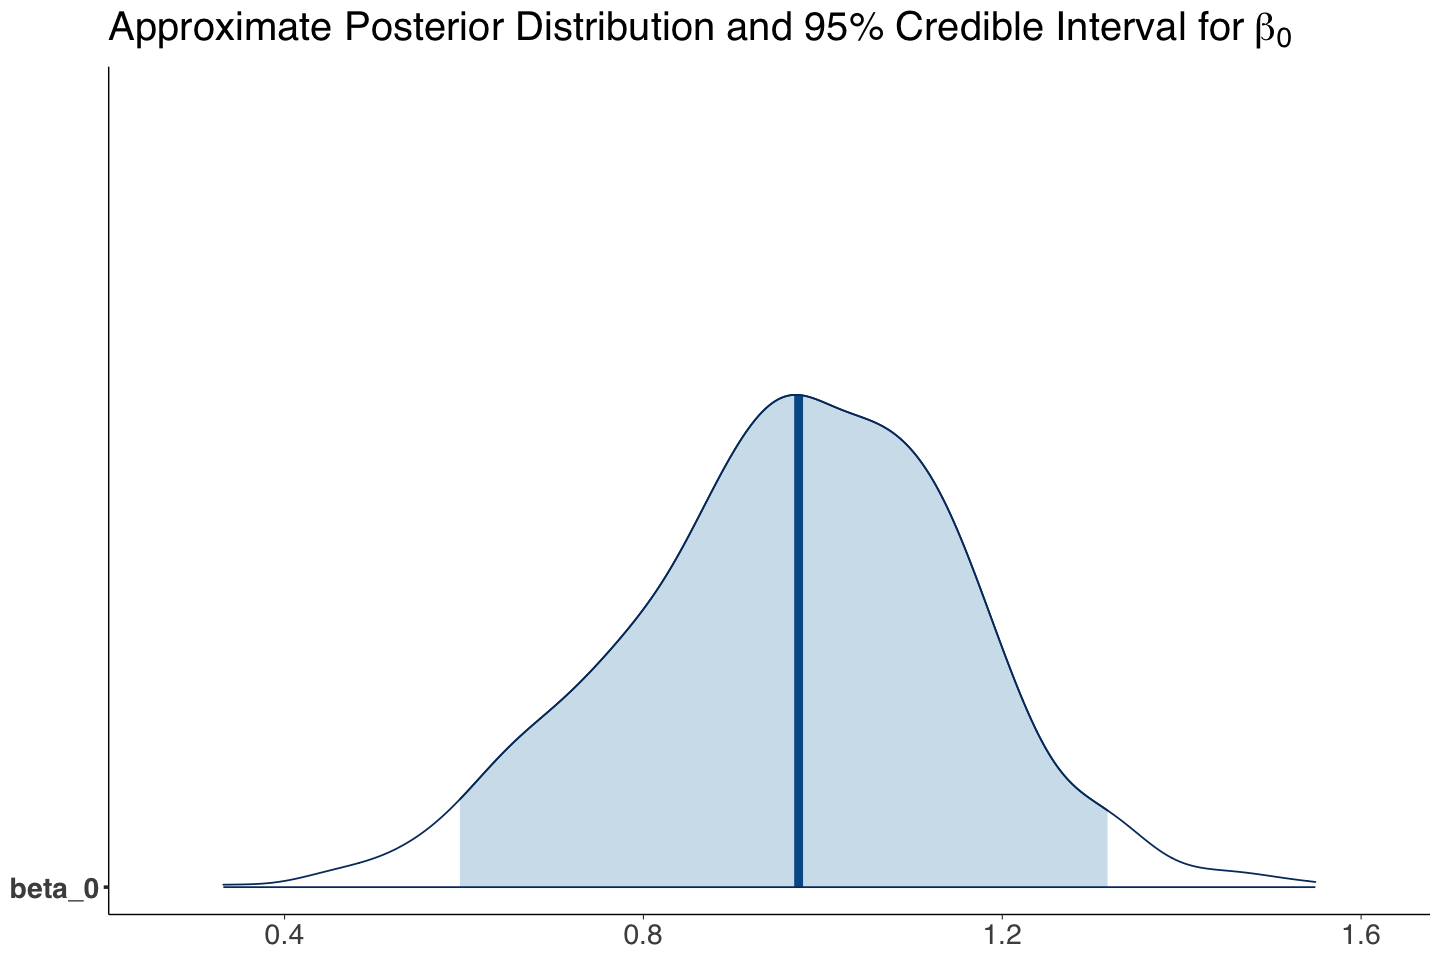

In [27]:
beta_0_post_dist

In [28]:
beta_1_post_dist <- mcmc_areas(posterior_climate, pars = c("beta_1"), prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  labs(title = expression("Approximate Posterior Distribution and 95% Credible Interval for" ~ beta[1]))

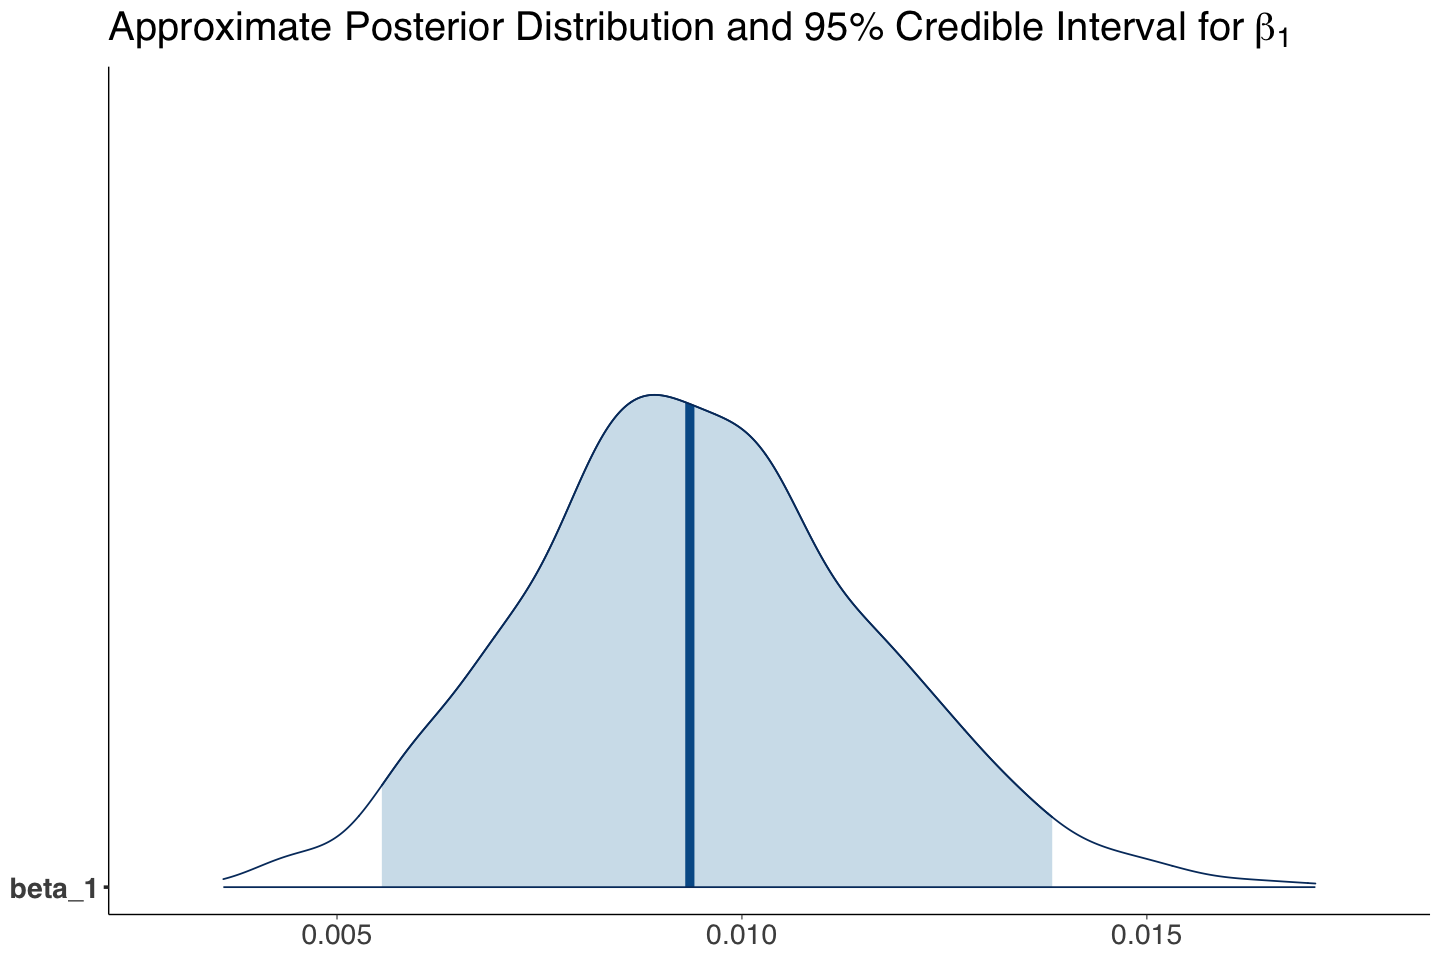

In [29]:
beta_1_post_dist

Again, the 1000 posterior samples (pairs containing $\beta_0$ and $\beta_1$) will be use to plot 1000 different sigmoid functions:

```{math}
\begin{equation*}
\pi_i = \frac{\exp\big[\beta_0 + \beta_1 X_{i,\text{income}}\big]}{1 + \exp\big[\beta_0 + \beta_1 X_{i,\text{income}}\big]} \in [0 ,1].
\end{equation*}
```

The regressor income is set up as a grid from 0 to 500 thousand USD to obtain these 1000 sigmoid functions.

In [30]:
posterior_climate <- as.data.frame(posterior_climate) # posterior_climate as data frame

income <- seq(0, 500, length.out = 500) # Setting up grid for income

beta_0 <- as.numeric(posterior_climate[1, "beta_0"]) # First sample
beta_1 <- as.numeric(posterior_climate[1, "beta_1"]) # First sample

logistic_like <- data.frame(income = income) |> # Computing probabilities with first sample
  mutate(values = exp(beta_0 + beta_1 * income) / (1 + exp(beta_0 + beta_1 * income)))

plot_logistic_like_posterior_stanfit <- ggplot(data = logistic_like, na.rm = TRUE) +
  geom_line(aes(x = income, y = values), alpha = 0.1, color = "darkred", na.rm = TRUE) +
  labs(y = "Probability of Believing Climate is Real", x = "Income (Thousand USD)") +
  ggtitle("Posterior Sigmoid Functions") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) # First ggplot layer

for (j in 2:nrow(posterior_climate)) # Loop from the second sample to the last sample in prior_climate
{
  beta_0 <- as.numeric(posterior_climate[j, "beta_0"])
  beta_1 <- as.numeric(posterior_climate[j, "beta_1"])
    
  logistic_like <- data.frame(income = income) |>
    mutate(values = exp(beta_0 + beta_1 * income) / (1 + exp(beta_0 + beta_1 * income)))
    
  plot_logistic_like_posterior_stanfit <- plot_logistic_like_posterior_stanfit +
    geom_line(data = logistic_like, aes(x = income, y = values), 
              alpha = 0.4, color = "darkred", na.rm = TRUE) # Next ggplot layer
}

The plot below shows these 1000 sigmoid functions. **This is a posterior distribution over curves (since a curve is defined by $\beta_0$ and $\beta_1$). Hence, these red sigmoid curves are samples from this distribution.**

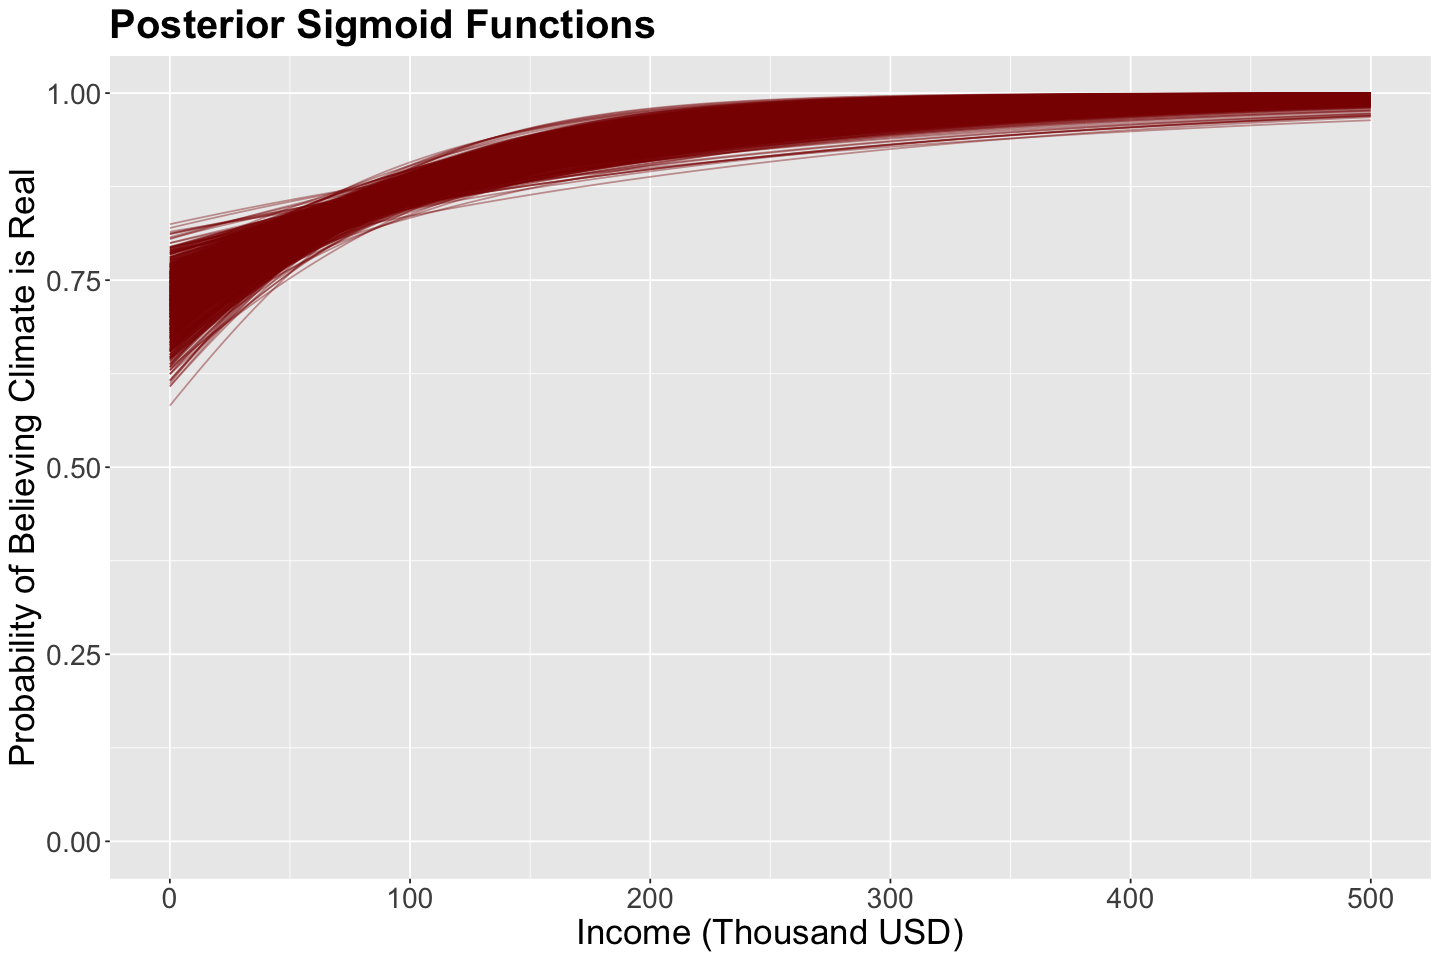

In [31]:
plot_logistic_like_posterior_stanfit + ylim(0, 1)

Now, we have a clear pattern in this posterior distribution! This is the likelihood (i.e., your data) in conjunction with the prior distribution via the Bayes' rule.

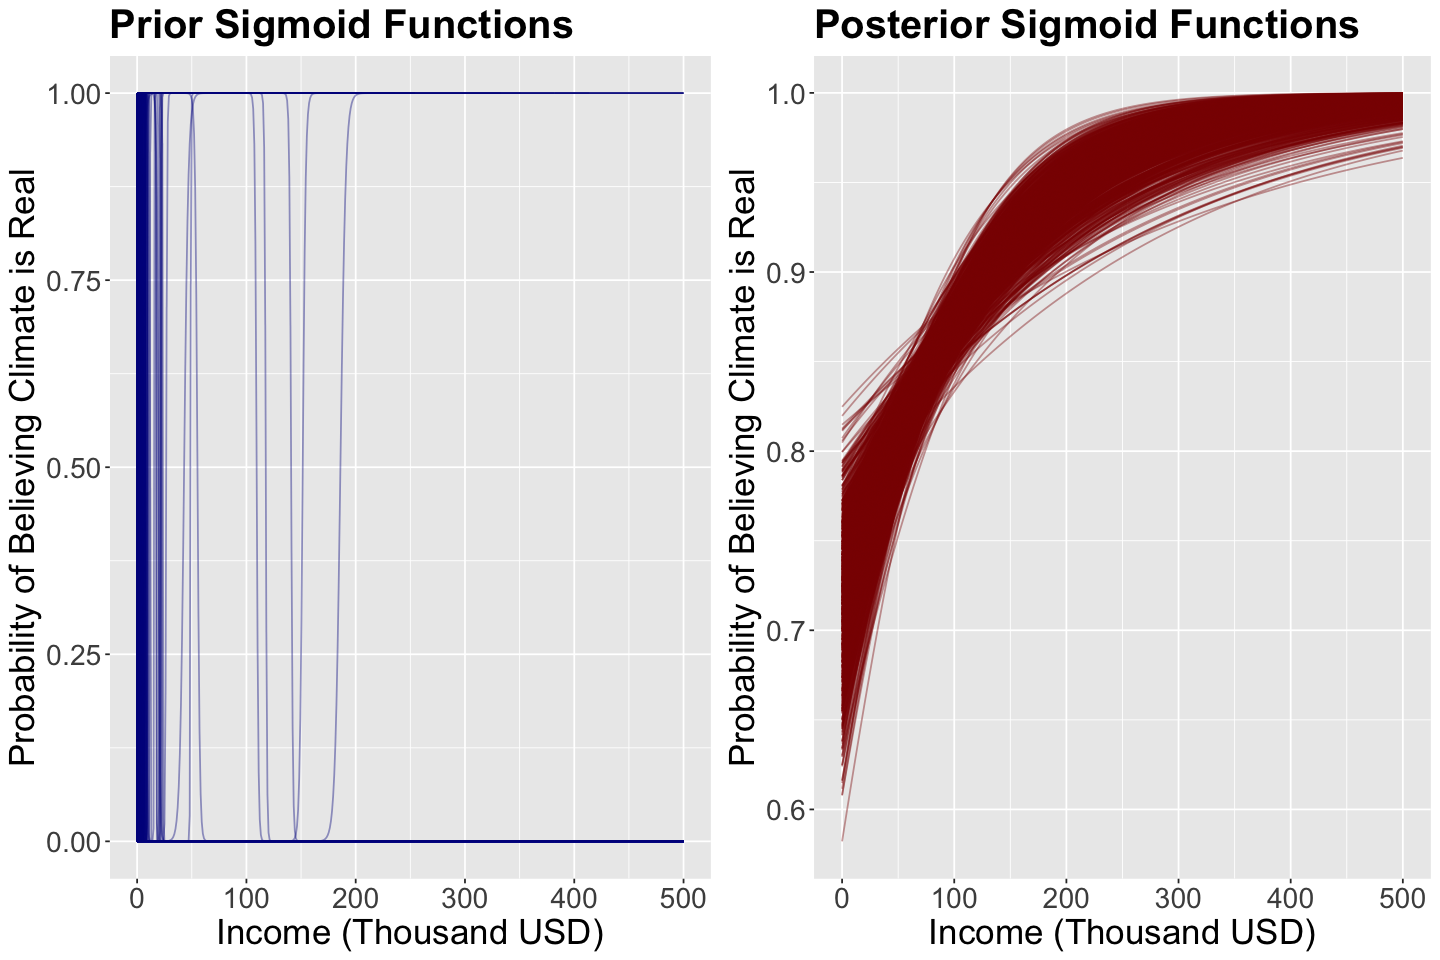

In [32]:
plot_grid(plot_logistic_like_prior_stanfit, plot_logistic_like_posterior_stanfit)

### 4.5. Distributions of Predicted Probabilities

Suppose you want to obtain **the prior distribution of predicted probabilities of success** (i.e., **a subject believing in climate change**) with an income of 100 thousand USD. We will use our 1000 prior samples in `prior_climate` for $\beta_0$ and $\beta_1$ to do so.

Note you will find `NaN`s in some rows since the predicted probabilities are so small that we encounter numerical errors. 

In [33]:
prior_climate <- prior_climate |>
  mutate(probability_believing = exp(beta_0 + beta_1 * 100) / (1 + exp(beta_0 + beta_1 * 100)))
head(prior_climate)

,beta_0,beta_1,lp__,probability_believing
,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.496540,130.56652,-0.8524928,NaN
2,24.444430,155.43653,-1.2379023,NaN
3,59.631513,-21.02121,-0.1998904,0
4,-4.196843,69.27654,-0.2408426,NaN
5,40.825609,28.84540,-0.1249394,NaN
6,-48.995753,84.73686,-0.4790460,NaN


We were not able to compute the 1000 prior probabilities. Nonetheless, the ones we could calculate are zero or close to zero. Therefore, this is not an informative predictive distribution for an income of 100 thousand USD.

In [34]:
hist_100_prior <- prior_climate |>
  ggplot() +
  geom_histogram(aes(probability_believing), fill = "grey", color = "darkblue", bins = 20, na.rm = TRUE) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  ggtitle("Histogram of Prior Estimated Believing Probabilities at 100 Thousand USD") +
  labs(x = "Believing Probability", y = "Count")

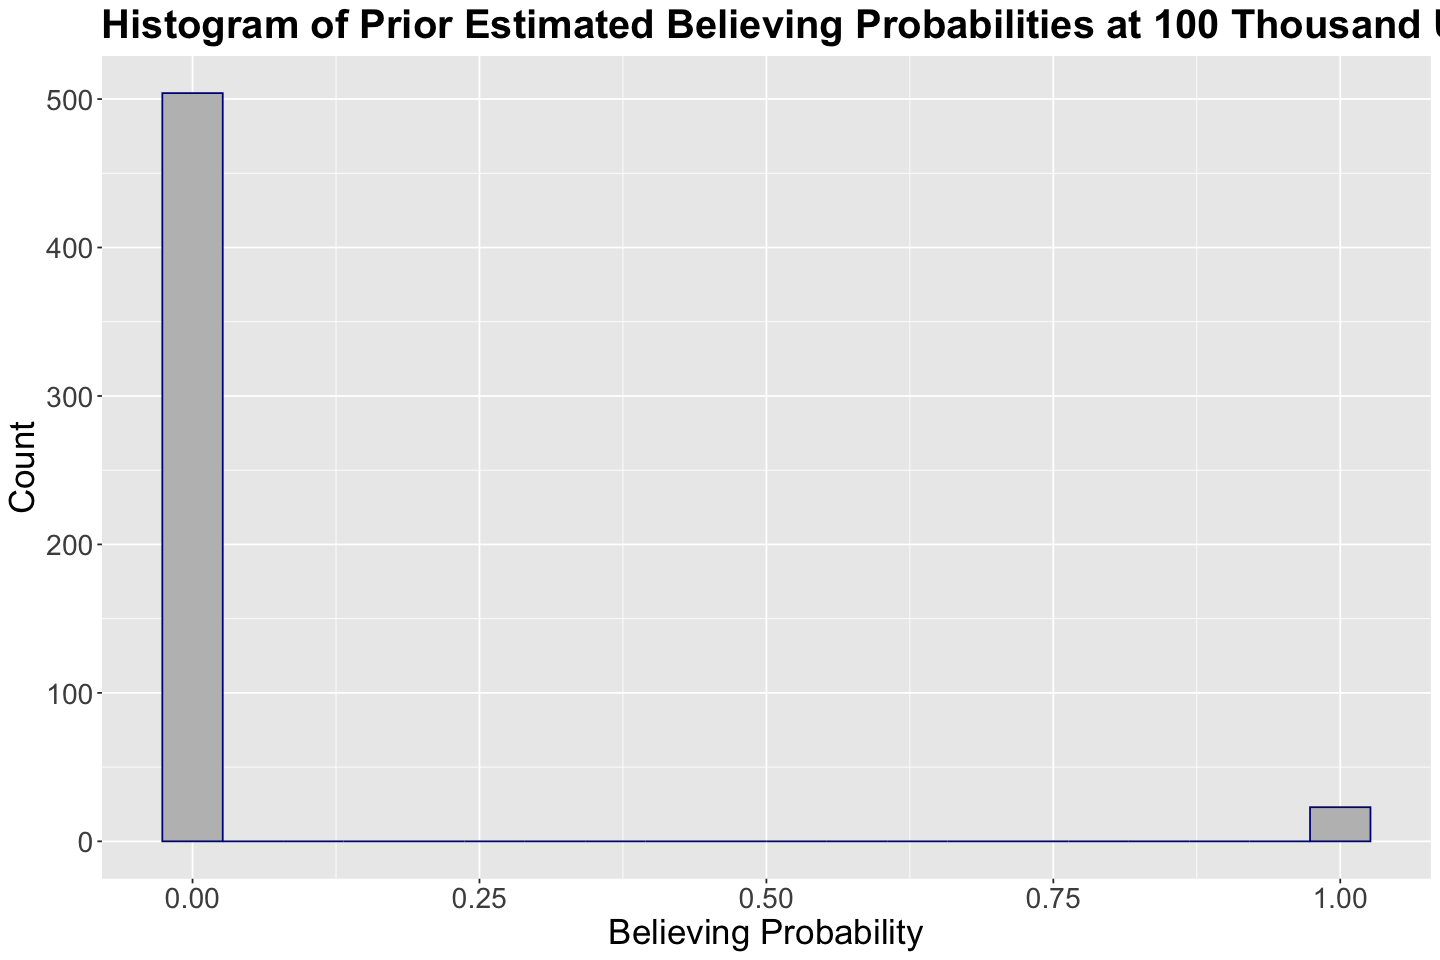

In [35]:
hist_100_prior

Now, let us follow the same process with `posterior_climate`.

In [36]:
posterior_climate <- posterior_climate |>
  mutate(probability_believing = exp(beta_0 + beta_1 * 100) / (1 + exp(beta_0 + beta_1 * 100)))
head(posterior_climate)

round(mean(posterior_climate$probability_believing), 2) # Mean predicted probability

,beta_0,beta_1,lp__,probability_believing
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9704702,0.007264117,-413.4656,0.8451271
2,0.7640832,0.012281058,-412.2110,0.8799745
3,0.8504562,0.010322106,-411.5658,0.8679171
4,1.0570489,0.009500551,-411.9428,0.8815409
5,0.7329129,0.011229681,-412.2951,0.8648161
6,1.0641366,0.009201498,-411.7768,0.8791374


[1] 0.87

The predictive posterior distribution for the probability of success is more reasonable! We have a mean prediction of 0.87. **The distribution is relatively symmetric.** With an income of 100 thousand USD, the posterior predicted probability leans more towards believing in climate change.

In [37]:
hist_100_posterior <- posterior_climate |>
  ggplot() +
  geom_histogram(aes(probability_believing), fill = "grey", color = "darkred", bins = 20) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  ggtitle("Histogram of Posterior Estimated Believing Probabilities at 100 Thousand USD") +
  labs(x = "Believing Probability", y = "Count")

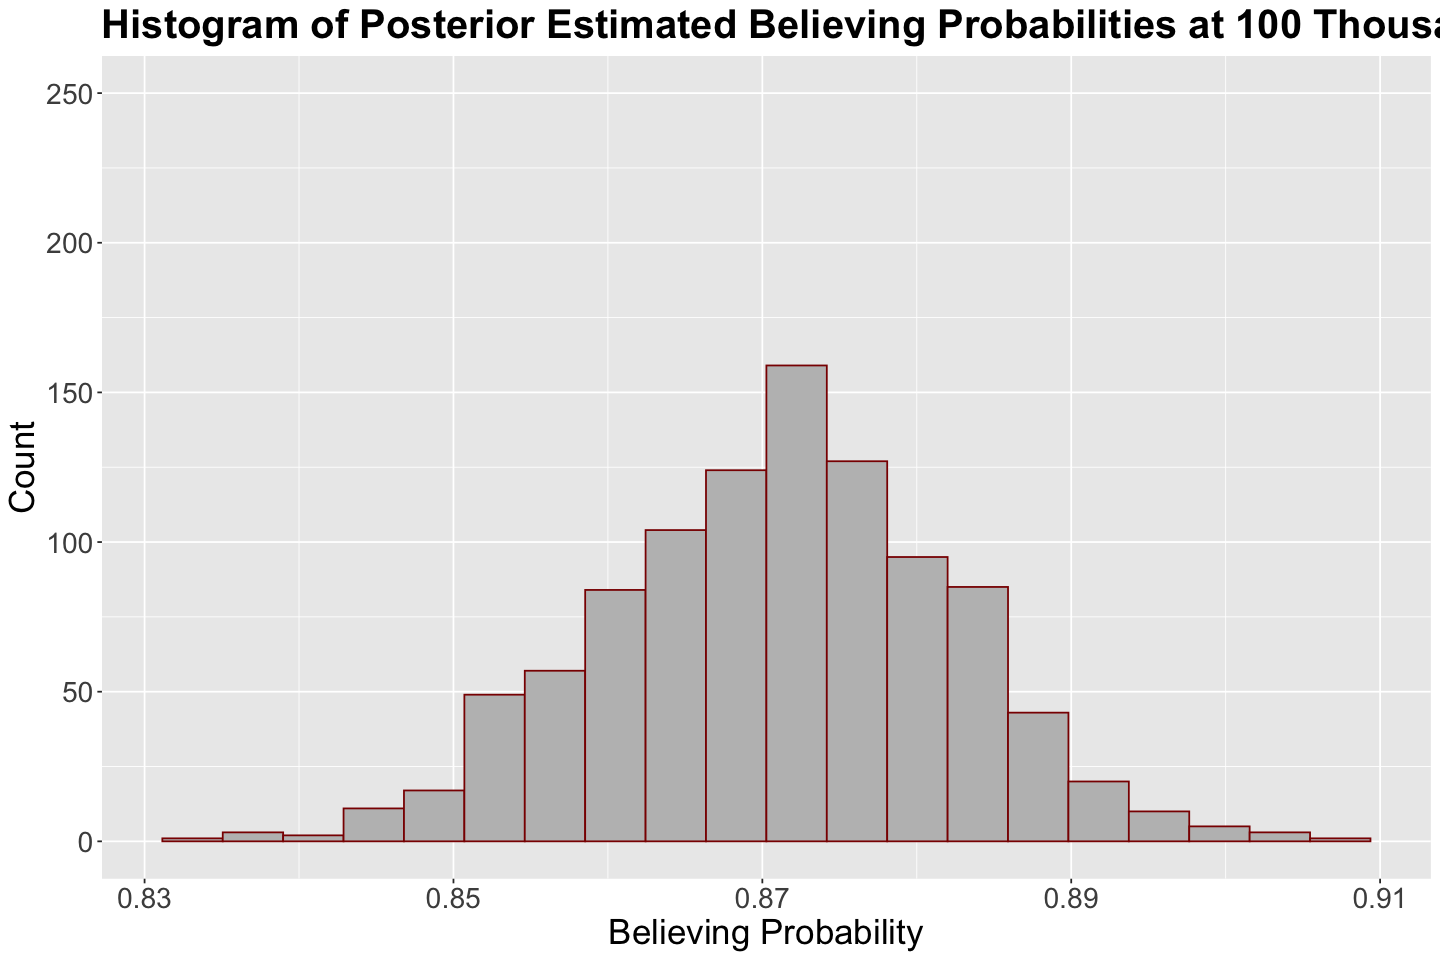

In [38]:
hist_100_posterior + ylim(0, 250) 

## 5. Wrapping Up

- We extended Bayesian regression to a GLM approach while keeping one of the core components: the link function.
- The inferential conclusions are done as in Bayesian Normal regression.
- We can also build posterior predictive distributions in a Binary Logistic regression framework.
- This Bayesian GLM approach can be applied to other models of this class with the proper arrangements (e.g., count regression, multinomial logistic regression, etc.).